# Predicting High Performing employees leaving a company

In [0]:
import pandas as pd
pd.options.display.max_rows = 999

from google.colab import drive
drive.mount('/content/gdrive', force_remount = False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#why this don't work 
#pip install gspread
#path2='/content/gdrive/My Drive/Data Sets/HR Data/hr-data.gsheet'
#df2=pd.read_excel(path2)
#df2.head()

In [0]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, log_loss

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, RandomizedSearchCV

import datetime

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier


In [0]:
path='/content/gdrive/My Drive/3 - Projects/HR Data/hr-data.csv'
df = pd.read_csv(path)
df.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,low
1,1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,3,0.72,0.87,5,223,5,0,1,0,sales,low
4,4,0.37,0.52,2,159,3,0,1,0,sales,low


In [0]:
df.isna().sum()

id                       0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
churn                    0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [0]:
#trying columns from satisfaction level all the way to work accident for x, and set y as churn
X=df.loc[:,['satisfaction_level','last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years']]
y=df['churn']

In [0]:
X.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
0,0.38,0.53,2,157,3,0,0
1,0.80,0.86,5,262,6,0,0
2,0.11,0.88,7,272,4,0,0
3,0.72,0.87,5,223,5,0,0
4,0.37,0.52,2,159,3,0,0


In [0]:
y.sum()

3571

In [0]:
#train test split
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
#doubling the churn values and appending it at the end(instead of smote-ing)
train_churn_y_index=y_train.loc[y_train==1].index
churn_y=y_train.loc[train_churn_y_index]
new_y_train=pd.concat([y_train,churn_y], ignore_index=True)
new_y_train.shape

(14864,)

In [0]:
new_y_train.sum()

5730

In [0]:
churn_x=X_train.loc[train_churn_y_index]
new_X_train=pd.concat([X_train,churn_x],ignore_index=True)
new_X_train.shape

(14864, 7)

In [0]:
new_X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
0,1.00,0.61,3,188,4,0,0
1,0.16,0.78,4,196,5,0,0
2,0.80,0.80,3,175,2,0,0
3,0.66,0.86,4,112,6,0,0
4,0.11,0.93,7,284,4,0,0


In [0]:
#scale X
std_scaler=StandardScaler()
std_scaler.fit(new_X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
#transform train and test
X_train_scale=std_scaler.transform(new_X_train)
X_test_scale=std_scaler.transform(X_test)


In [0]:
X_train_scale.shape

(14864, 7)

In [0]:
new_y_train.shape

(14864,)

In [0]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42,n_jobs=-1)
clf1.fit(X_train_scale,new_y_train)
y_val_pred=clf1.predict_proba(X_test_scale)
log_loss(y_test, y_val_pred)

0.4903599347395037

In [0]:
clf2 = RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=42,n_jobs=-1)
clf2.fit(X_train_scale,new_y_train)
y_val_pred=clf2.predict_proba(X_test_scale)
log_loss(y_test, y_val_pred)

0.1401074694496898

In [0]:
clf3 = XGBClassifier(random_state=42,n_jobs=-1)
clf3.fit(X_train_scale,new_y_train)
y_val_pred = clf3.predict_proba(X_test_scale)
log_loss(y_test, y_val_pred)

0.10477856504255517

In [0]:
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft')
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'XGB', 'Ensemble']):
  scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.74 (+/- 0.06) [Logistic Regression]
Accuracy: 0.99 (+/- 0.01) [Random Forest]
Accuracy: 0.97 (+/- 0.00) [XGB]
Accuracy: 0.98 (+/- 0.00) [Ensemble]


In [0]:
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb',clf3)], voting='soft', n_jobs=-1)
eclf.fit(X_train_scale, new_y_train)
y_val_pred = eclf.predict_proba(X_test_scale)
log_loss(y_test, y_val_pred)

0.16872818745585877

In [0]:
eclf.feature

AttributeError: ignored

In [0]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels



In [0]:
std_scaler.fit(data)
centers, labels = find_clusters(data, 4)
plt.scatter(data[:, 0], data[:, 1], c=labels,
            s=50, cmap='viridis');

KeyError: ignored

In [0]:
churn1=df.loc[(df['churn']==1) & (df['time_spend_company']==1)]
churn2=df.loc[(df['churn']==1) & (df['time_spend_company']==2)]
churn3=df.loc[(df['churn']==1) & (df['time_spend_company']==3)]
churn4=df.loc[(df['churn']==1) & (df['time_spend_company']==4)]
churn5=df.loc[(df['churn']==1) & (df['time_spend_company']==5)]
churn6=df.loc[(df['churn']==1) & (df['time_spend_company']==6)]
churn7=df.loc[(df['churn']==1) & (df['time_spend_company']==7)]
churn8=df.loc[(df['churn']==1) & (df['time_spend_company']==8)]
churn9=df.loc[(df['churn']==1) & (df['time_spend_company']==9)]

In [0]:
churn8.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
churn9.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
churn2.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.000000,53.0,53.0
mean,6170.528302,0.521698,0.753208,4.056604,210.773585,2.0,0.018868,1.0,0.0
std,6245.243863,0.239284,0.139956,1.307009,48.799291,0.0,0.137361,0.0,0.0
min,50.000000,0.090000,0.450000,2.000000,128.000000,2.0,0.000000,1.0,0.0
25%,805.000000,0.340000,0.680000,3.000000,168.000000,2.0,0.000000,1.0,0.0
50%,1674.000000,0.560000,0.750000,4.000000,214.000000,2.0,0.000000,1.0,0.0
75%,12631.000000,0.730000,0.860000,5.000000,252.000000,2.0,0.000000,1.0,0.0
max,14961.000000,0.890000,1.000000,7.000000,296.000000,2.0,1.000000,1.0,0.0


In [0]:
churn3.sales.value_counts()

sales          478
technical      265
support        242
IT             115
hr             115
marketing      106
accounting      92
product_mng     88
RandD           45
management      40
Name: sales, dtype: int64

In [0]:
df.loc[(df['sales']=='technical') & (df['last_evaluation']>0.8) & (df['churn']==0)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.0,684.000000
mean,7149.980994,0.683772,0.905058,3.846491,202.730994,3.288012,0.166667,0.0,0.010234
std,3262.363867,0.219218,0.056303,0.956508,45.019835,1.393491,0.372951,0.0,0.100718
min,2019.000000,0.120000,0.810000,2.000000,98.000000,2.000000,0.000000,0.0,0.000000
25%,4387.750000,0.570000,0.860000,3.000000,166.000000,2.000000,0.000000,0.0,0.000000
50%,6767.000000,0.700000,0.910000,4.000000,202.500000,3.000000,0.000000,0.0,0.000000
75%,9735.250000,0.860000,0.950000,4.000000,242.000000,4.000000,0.000000,0.0,0.000000
max,14032.000000,1.000000,1.000000,6.000000,287.000000,10.000000,1.000000,0.0,1.000000


In [0]:
w=df.loc[(df['time_spend_company']>6) & (df['churn']==0)]


count       564
unique       10
top       sales
freq        216
Name: sales, dtype: object

In [0]:
df.loc[(df['time_spend_company']>6) & (df['last_evaluation']>0.8) & (df['churn']==0)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.0,188.000000
mean,12632.617021,0.659149,0.892872,3.872340,200.436170,8.489362,0.170213,0.0,0.117021
std,1138.931440,0.209684,0.051327,0.904345,44.318381,1.281248,0.376823,0.0,0.322304
min,11008.000000,0.160000,0.810000,2.000000,117.000000,7.000000,0.000000,0.0,0.000000
25%,11566.500000,0.550000,0.850000,3.000000,157.000000,7.000000,0.000000,0.0,0.000000
50%,12607.500000,0.650000,0.890000,4.000000,203.500000,8.000000,0.000000,0.0,0.000000
75%,13776.500000,0.840000,0.920000,4.000000,238.000000,10.000000,0.000000,0.0,0.000000
max,14207.000000,0.990000,1.000000,6.000000,285.000000,10.000000,1.000000,0.0,1.000000


In [0]:
df.loc[(df['sales']=='IT') & (df['last_evaluation']<0.5) & (df['churn']==1)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,39.000000,39.000000,39.000000,39.0,39.000000,39.000000,39.000000,39.0,39.000000
mean,5529.153846,0.393077,0.470256,2.0,147.948718,3.025641,0.051282,1.0,0.051282
std,6038.041511,0.035552,0.014233,0.0,19.203822,0.160128,0.223456,0.0,0.223456
min,216.000000,0.290000,0.450000,2.0,127.000000,3.000000,0.000000,1.0,0.000000
25%,977.500000,0.370000,0.460000,2.0,140.500000,3.000000,0.000000,1.0,0.000000
50%,1521.000000,0.380000,0.470000,2.0,145.000000,3.000000,0.000000,1.0,0.000000
75%,12522.000000,0.415000,0.480000,2.0,154.500000,3.000000,0.000000,1.0,0.000000
max,14932.000000,0.460000,0.490000,2.0,249.000000,4.000000,1.000000,1.0,1.000000


In [0]:
df.loc[(df['sales']=='IT') & (df['last_evaluation']<0.5) & (df['churn']==0)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.00000,75.0,75.0
mean,8685.893333,0.582933,0.455867,3.440000,192.626667,3.666667,0.12000,0.0,0.0
std,3506.237340,0.224119,0.036580,1.068467,56.159227,1.426897,0.32715,0.0,0.0
min,2125.000000,0.120000,0.370000,2.000000,97.000000,2.000000,0.00000,0.0,0.0
25%,6097.500000,0.405000,0.430000,3.000000,147.000000,3.000000,0.00000,0.0,0.0
50%,9220.000000,0.580000,0.470000,3.000000,186.000000,3.000000,0.00000,0.0,0.0
75%,11434.000000,0.780000,0.480000,4.000000,243.000000,4.000000,0.00000,0.0,0.0
max,14174.000000,1.000000,0.490000,6.000000,287.000000,7.000000,1.00000,0.0,0.0


In [0]:
df.loc[(df['sales']=='sales') & (df['last_evaluation']>0.8) & (df['churn']==1)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.0,468.000000
mean,6458.309829,0.512799,0.910299,5.226496,256.598291,4.623932,0.032051,1.0,0.002137
std,6264.708586,0.351690,0.057592,1.065310,27.035090,0.776822,0.176325,0.0,0.046225
min,1.000000,0.090000,0.810000,2.000000,131.000000,2.000000,0.000000,1.0,0.000000
25%,857.500000,0.110000,0.860000,5.000000,242.750000,4.000000,0.000000,1.0,0.000000
50%,1766.000000,0.730000,0.910000,5.000000,257.000000,5.000000,0.000000,1.0,0.000000
75%,12689.000000,0.820000,0.960000,6.000000,272.250000,5.000000,0.000000,1.0,0.000000
max,14970.000000,0.920000,1.000000,7.000000,310.000000,6.000000,1.000000,1.0,1.000000


In [0]:
df.loc[(df['sales']=='sales') & (df['last_evaluation']>0.8) & (df['churn']==0)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.0,985.000000
mean,7991.215228,0.684690,0.901675,3.827411,203.245685,3.476142,0.175635,0.0,0.039594
std,3498.680631,0.219966,0.058257,0.951390,44.675507,1.610966,0.380702,0.0,0.195102
min,2003.000000,0.120000,0.810000,2.000000,96.000000,2.000000,0.000000,0.0,0.000000
25%,4969.000000,0.550000,0.850000,3.000000,167.000000,2.000000,0.000000,0.0,0.000000
50%,7883.000000,0.710000,0.900000,4.000000,203.000000,3.000000,0.000000,0.0,0.000000
75%,10862.000000,0.860000,0.960000,4.000000,241.000000,4.000000,0.000000,0.0,0.000000
max,14192.000000,1.000000,1.000000,6.000000,287.000000,10.000000,1.000000,0.0,1.000000


In [0]:
df.loc[(df['time_spend_company']>6) & (df['churn']==0)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.0,564.000000
mean,12686.684397,0.651667,0.709645,3.765957,198.173759,8.425532,0.212766,0.0,0.109929
std,1135.720069,0.225363,0.161216,0.994752,47.978181,1.293427,0.409627,0.0,0.313079
min,11007.000000,0.140000,0.370000,2.000000,100.000000,7.000000,0.000000,0.0,0.000000
25%,11606.750000,0.500000,0.590000,3.000000,156.000000,7.000000,0.000000,0.0,0.000000
50%,12608.000000,0.660000,0.715000,4.000000,199.500000,8.000000,0.000000,0.0,0.000000
75%,13817.250000,0.850000,0.850000,4.000000,239.000000,10.000000,0.000000,0.0,0.000000
max,14209.000000,1.000000,1.000000,6.000000,286.000000,10.000000,1.000000,0.0,1.000000


In [0]:
churn3.loc[(churn3['sales']=='management')].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.0,40.000000
mean,6025.275000,0.461250,0.531750,2.325000,147.350000,3.0,0.100000,1.0,0.075000
std,6211.514176,0.142454,0.110683,0.916725,29.744683,0.0,0.303822,0.0,0.266747
min,82.000000,0.360000,0.460000,2.000000,127.000000,3.0,0.000000,1.0,0.000000
25%,1052.000000,0.390000,0.480000,2.000000,131.250000,3.0,0.000000,1.0,0.000000
50%,1674.500000,0.420000,0.500000,2.000000,140.500000,3.0,0.000000,1.0,0.000000
75%,12575.000000,0.440000,0.540000,2.000000,152.250000,3.0,0.000000,1.0,0.000000
max,14949.000000,0.900000,1.000000,6.000000,275.000000,3.0,1.000000,1.0,1.000000


In [0]:
churn3.loc[(churn3['sales']=='technical') & (churn3['last_evaluation']>0.8)].describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,4.000000,4.000000,4.000000,4.0,4.000000,4.0,4.0,4.0,4.0
mean,3972.000000,0.232500,0.892500,4.5,200.250000,3.0,0.0,1.0,0.0
std,5839.569961,0.096738,0.028723,1.0,66.785103,0.0,0.0,0.0,0.0
min,721.000000,0.110000,0.870000,4.0,138.000000,3.0,0.0,1.0,0.0
25%,953.500000,0.177500,0.870000,4.0,172.500000,3.0,0.0,1.0,0.0
50%,1223.000000,0.255000,0.885000,4.0,184.000000,3.0,0.0,1.0,0.0
75%,4241.500000,0.310000,0.907500,4.5,211.750000,3.0,0.0,1.0,0.0
max,12721.000000,0.310000,0.930000,6.0,295.000000,3.0,0.0,1.0,0.0


In [0]:
churn3.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.0,1586.000000,1586.0,1586.000000
mean,6550.741488,0.411740,0.520019,2.097730,147.377049,3.0,0.046658,1.0,0.009458
std,6271.268460,0.059594,0.066001,0.555927,22.792031,0.0,0.210972,0.0,0.096821
min,0.000000,0.100000,0.450000,2.000000,126.000000,3.0,0.000000,1.0,0.000000
25%,913.500000,0.380000,0.480000,2.000000,135.000000,3.0,0.000000,1.0,0.000000
50%,1805.000000,0.410000,0.510000,2.000000,145.000000,3.0,0.000000,1.0,0.000000
75%,12699.750000,0.440000,0.540000,2.000000,154.000000,3.0,0.000000,1.0,0.000000
max,14998.000000,0.900000,1.000000,7.000000,310.000000,3.0,1.000000,1.0,1.000000


In [0]:
churn4.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,890.000000,890.000000,890.000000,890.000000,890.000000,890.0,890.000000,890.0,890.000000
mean,6511.117978,0.146933,0.854000,5.960674,269.612360,4.0,0.050562,1.0,0.003371
std,6272.626364,0.148937,0.096593,0.978753,31.901939,0.0,0.219224,0.0,0.057993
min,2.000000,0.090000,0.450000,2.000000,130.000000,4.0,0.000000,1.0,0.000000
25%,860.250000,0.100000,0.810000,6.000000,255.000000,4.0,0.000000,1.0,0.000000
50%,1788.000000,0.100000,0.870000,6.000000,275.000000,4.0,0.000000,1.0,0.000000
75%,12679.000000,0.110000,0.920000,6.000000,291.000000,4.0,0.000000,1.0,0.000000
max,14997.000000,0.900000,1.000000,7.000000,310.000000,4.0,1.000000,1.0,1.000000


In [0]:
churn5.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,833.000000,833.000000,833.000000,833.000000,833.000000,833.0,833.000000,833.0,833.000000
mean,6294.274910,0.714034,0.901032,4.759904,246.337335,5.0,0.046819,1.0,0.001200
std,6235.021027,0.247469,0.094674,0.890644,28.917992,0.0,0.211377,0.0,0.034648
min,3.000000,0.090000,0.460000,2.000000,132.000000,5.0,0.000000,1.0,0.000000
25%,909.000000,0.740000,0.860000,4.000000,233.000000,5.0,0.000000,1.0,0.000000
50%,1703.000000,0.810000,0.920000,5.000000,248.000000,5.0,0.000000,1.0,0.000000
75%,12638.000000,0.860000,0.970000,5.000000,262.000000,5.0,0.000000,1.0,0.000000
max,14990.000000,0.920000,1.000000,7.000000,310.000000,5.0,1.000000,1.0,1.000000


In [0]:
churn6.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.0,209.000000,209.0,209.0
mean,6961.526316,0.791196,0.904737,4.574163,242.244019,6.0,0.047847,1.0,0.0
std,6359.739377,0.120460,0.096452,0.600883,26.751038,0.0,0.213955,0.0,0.0
min,1.000000,0.200000,0.500000,3.000000,132.000000,6.0,0.000000,1.0,0.0
25%,838.000000,0.760000,0.850000,4.000000,229.000000,6.0,0.000000,1.0,0.0
50%,1950.000000,0.810000,0.920000,5.000000,245.000000,6.0,0.000000,1.0,0.0
75%,12718.000000,0.870000,0.980000,5.000000,262.000000,6.0,0.000000,1.0,0.0
max,14993.000000,0.920000,1.000000,6.000000,293.000000,6.0,1.000000,1.0,0.0


In [0]:
churn7.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.loc[(df['churn']==1) & (df['number_project']<3)].sales.value_counts()

sales          477
technical      264
support        238
IT             114
hr             109
marketing      105
accounting      91
product_mng     88
RandD           46
management      35
Name: sales, dtype: int64

In [0]:
df_satis=df.loc[df['last_evaluation']>0.8]
df_satis.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
1,1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,3,0.72,0.87,5,223,5,0,1,0,sales,low
7,7,0.92,0.85,5,259,5,0,1,0,sales,low
8,8,0.89,1.00,5,224,5,0,1,0,sales,low


In [0]:
churny=df_satis.groupby(['sales']).churn.mean().round(2).sort_values()*100

[Text(0, 0, 'management'),
 Text(0, 0, 'RandD'),
 Text(0, 0, 'marketing'),
 Text(0, 0, 'hr'),
 Text(0, 0, 'IT'),
 Text(0, 0, 'accounting'),
 Text(0, 0, 'product_mng'),
 Text(0, 0, 'sales'),
 Text(0, 0, 'support'),
 Text(0, 0, 'technical')]

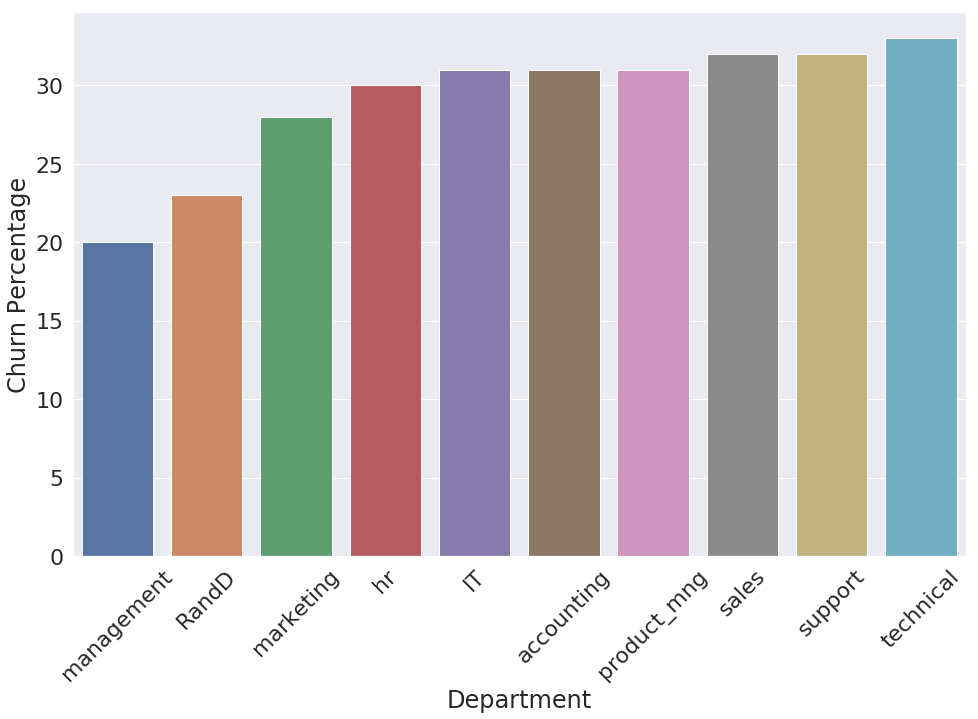

In [0]:
sns.set(rc={'figure.figsize':(16,10)})
sns.set(font_scale=2)
k=sns.barplot(churny.index,churny.values)
k.set(xlabel='Department', ylabel='Churn Percentage')
k.set_xticklabels(k.get_xticklabels(),rotation=45)

In [0]:
s=df.groupby(['sales']).churn.mean().sort_values().round(2)*100

[Text(0, 0, 'management'),
 Text(0, 0, 'RandD'),
 Text(0, 0, 'product_mng'),
 Text(0, 0, 'IT'),
 Text(0, 0, 'marketing'),
 Text(0, 0, 'sales'),
 Text(0, 0, 'support'),
 Text(0, 0, 'technical'),
 Text(0, 0, 'accounting'),
 Text(0, 0, 'hr')]

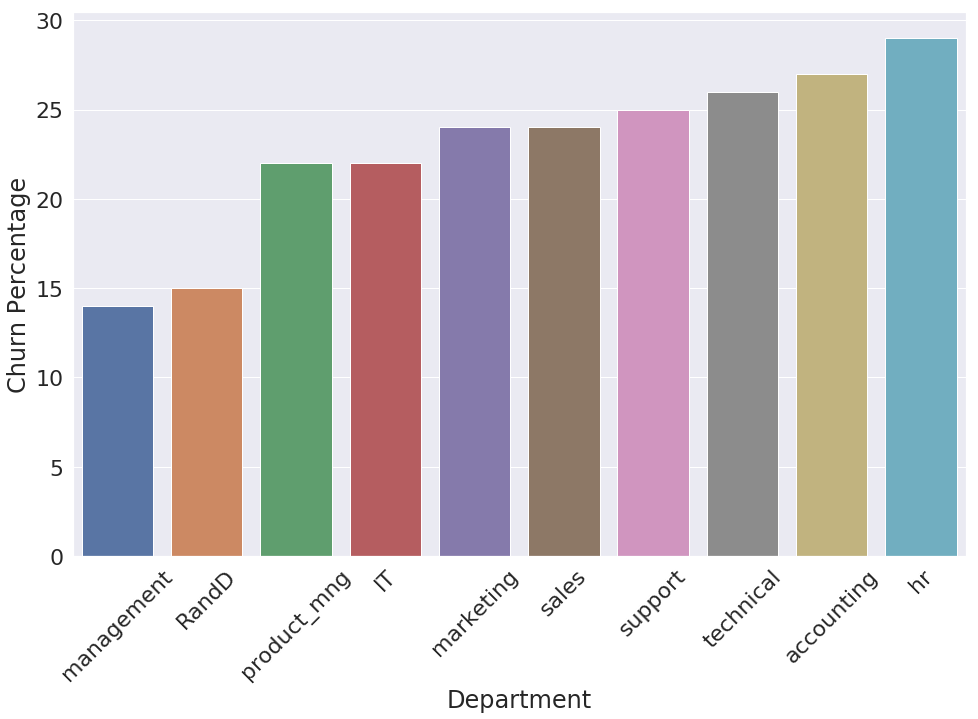

In [0]:
sns.set(rc={'figure.figsize':(16,10)})
sns.set(font_scale=2)
k=sns.barplot(s.index,s.values)
k.set(xlabel='Department', ylabel='Churn Percentage')
k.set_xticklabels(k.get_xticklabels(),rotation=45)

In [0]:
churn3.groupby(['sales']).number_project.describe()

,count,mean,std,min,25%,50%,75%,max
sales,,,,,,,,
IT,115.0,2.043478,0.383687,2.0,2.0,2.0,2.0,6.0
RandD,45.0,2.044444,0.298142,2.0,2.0,2.0,2.0,4.0
accounting,92.0,2.021739,0.208514,2.0,2.0,2.0,2.0,4.0
hr,115.0,2.113043,0.491421,2.0,2.0,2.0,2.0,5.0
management,40.0,2.325000,0.916725,2.0,2.0,2.0,2.0,6.0
marketing,106.0,2.084906,0.554083,2.0,2.0,2.0,2.0,7.0
product_mng,88.0,2.034091,0.319801,2.0,2.0,2.0,2.0,5.0
sales,478.0,2.104603,0.580555,2.0,2.0,2.0,2.0,7.0
support,242.0,2.086777,0.535765,2.0,2.0,2.0,2.0,6.0


In [0]:
churn3.groupby(['sales']).average_montly_hours.describe()

,count,mean,std,min,25%,50%,75%,max
sales,,,,,,,,
IT,115.0,146.826087,24.278451,127.0,131.50,145.0,154.50,277.0
RandD,45.0,140.844444,10.531243,127.0,133.00,137.0,148.00,161.0
accounting,92.0,142.847826,10.129854,127.0,135.00,143.0,152.25,160.0
hr,115.0,148.060870,24.683359,126.0,136.00,143.0,151.00,296.0
management,40.0,147.350000,29.744683,127.0,131.25,140.5,152.25,275.0
marketing,106.0,146.264151,18.935631,127.0,136.00,146.0,152.00,293.0
product_mng,88.0,149.818182,26.039998,129.0,139.75,147.0,153.00,310.0
sales,478.0,147.920502,19.373466,126.0,136.00,147.0,156.00,294.0
support,242.0,147.404959,22.918611,126.0,135.00,145.0,153.00,301.0


In [0]:
churn6.groupby(['sales']).average_montly_hours.describe()

,count,mean,std,min,25%,50%,75%,max
sales,,,,,,,,
IT,7.0,230.285714,44.794770,132.0,239.00,239.0,246.00,271.0
RandD,5.0,191.800000,52.713376,135.0,135.00,220.0,224.00,245.0
accounting,8.0,243.375000,18.329816,222.0,223.00,246.5,262.00,262.0
hr,13.0,250.615385,18.980422,229.0,244.00,246.0,251.00,281.0
management,2.0,233.500000,2.121320,232.0,232.75,233.5,234.25,235.0
marketing,18.0,244.833333,10.433261,226.0,239.25,242.5,249.00,275.0
product_mng,17.0,242.352941,21.903028,217.0,222.00,236.0,264.00,276.0
sales,48.0,250.770833,13.210633,220.0,244.00,255.0,262.00,269.0
support,48.0,243.125000,27.304138,165.0,222.50,249.5,264.00,293.0


In [0]:
X2=churn2.loc[:,['satisfaction_level','last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years']]
y2=churn2['churn']

In [0]:
X2_train, X2_test, y2_train,y2_test=train_test_split(X2,y2,test_size=0.2,random_state=42)

In [0]:
#scale X
std_scaler=StandardScaler()
std_scaler.fit(X2_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
#transform train and test
X2_train_scale=std_scaler.transform(X2_train)
X2_test_scale=std_scaler.transform(X2_test)


In [0]:
train_churn_y2_index=y2_train.loc[y2_train==1].index
churn_y2=y2_train.loc[train_churn_y2_index]
new_y2_train=pd.concat([y2_train,churn_y2], ignore_index=True)
new_y2_train.shape

(84,)

In [0]:
churn_x2=X2_train.loc[train_churn_y_index]
new_X2_train=pd.concat([X2_train,churn_x2],ignore_index=True)
new_X2_train.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


(2907, 7)

In [0]:
#adjust samples to fix imbalance in target classes by SMOTE
sm = SMOTE()

X2_train_smote, y2_train_smote = sm.fit_sample(X2_train_scale,y2_train)

X2_train_smote = pd.DataFrame(X2_train_smote,columns=['satisfaction_level','last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years'])

ValueError: ignored

In [0]:
churn1.shape

(0, 11)

In [0]:
churn2.shape

(53, 11)

In [0]:
churn3.shape

(1586, 11)

In [0]:
churn4.shape

(890, 11)

In [0]:
churn5.shape

(833, 11)

In [0]:
churn6.shape

(209, 11)

In [0]:
churn7.shape

(0, 11)

In [0]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf2 = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the Classifier to take the training features and learn how they relate
# to the training y
clf2.fit(X2_train_scale, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: ignored

In [0]:
df.columns

Index(['id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'churn',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [0]:
df.describe()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,4329.982679,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,3749.500000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,7499.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,11248.500000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,14998.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [0]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV

import datetime

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE


# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
df.shape

(14999, 11)

In [0]:
df.churn.sum()

3571

In [0]:
df.loc[df['last_evaluation']>0.8].shape

(5489, 11)

In [0]:
a=df.loc[df['last_evaluation']>0.8].groupby(['sales'])

In [0]:
b=df.loc[df['time_spend_company']].groupby('sales').churn
len(a)

10

In [0]:
df.groupby(['sales']).churn.mean()*100

sales
IT             22.249389
RandD          15.374841
accounting     26.597132
hr             29.093369
management     14.444444
marketing      23.659674
product_mng    21.951220
sales          24.492754
support        24.899058
technical      25.625000
Name: churn, dtype: float64

(array([1335.,  498.,  477., 1778., 1471., 1775., 1768., 2115., 1998.,
        1784.]),
 array([0.09 , 0.181, 0.272, 0.363, 0.454, 0.545, 0.636, 0.727, 0.818,
        0.909, 1.   ]),
 <a list of 10 Patch objects>)

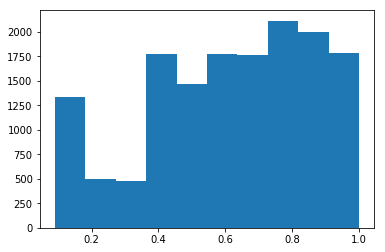

In [0]:
plt.hist(df['satisfaction_level'])

(array([ 367., 1240., 2733., 1722., 1628., 1712., 1906., 2240., 1127.,
         324.]),
 array([ 96. , 117.4, 138.8, 160.2, 181.6, 203. , 224.4, 245.8, 267.2,
        288.6, 310. ]),
 <a list of 10 Patch objects>)

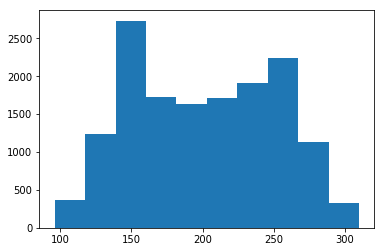

In [0]:
plt.hist(df['average_montly_hours'])

(array([12830.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2169.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

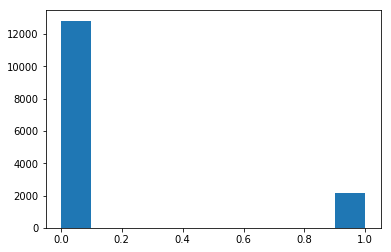

In [0]:
plt.hist(df['Work_accident'])

(array([3244., 6443., 2557., 1473.,    0.,  718.,  188.,  162.,    0.,
         214.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <a list of 10 Patch objects>)

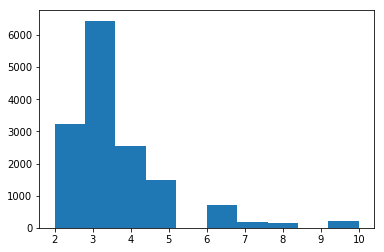

In [0]:
plt.hist(df['time_spend_company'])

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
df.columns

Index(['id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'churn',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [0]:
#trying columns from satisfaction level all the way to work accident for x, and set y as churn
X=df.loc[:,['satisfaction_level','last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years']]
y=df['churn']

In [0]:
#train test split
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
train_churn_y_index=y_train.loc[y_train==1].index
churn_y=y_train.loc[train_churn_y_index]
new_y_train=pd.concat([y_train,churn_y], ignore_index=True)
new_y_train.shape

(14864,)

In [0]:
new_y_train.head()

0    0
1    0
2    0
3    0
4    1
Name: churn, dtype: int64

In [0]:
churn_x=X_train.loc[train_churn_y_index]
new_X_train=pd.concat([X_train,churn_x],ignore_index=True)
new_X_train.shape

(14864, 7)

In [0]:
#scale X
std_scaler=StandardScaler()
std_scaler.fit(new_X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
#transform train and test
X_train_scale=std_scaler.transform(new_X_train)
X_test_scale=std_scaler.transform(X_test)


In [0]:
#adjust samples to fix imbalance in target classes by SMOTE
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_scale,new_y_train)

X_train_smote = pd.DataFrame(X_train_smote,columns=['satisfaction_level','last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years'])

In [0]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the Classifier to take the training features and learn how they relate
# to the training y
clf.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

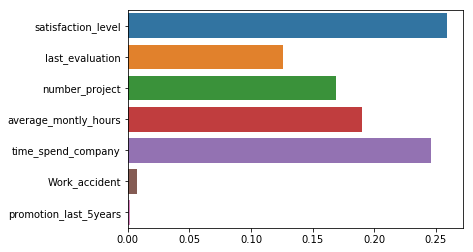

In [0]:
sns.barplot(clf.feature_importances_,new_X_train.columns)

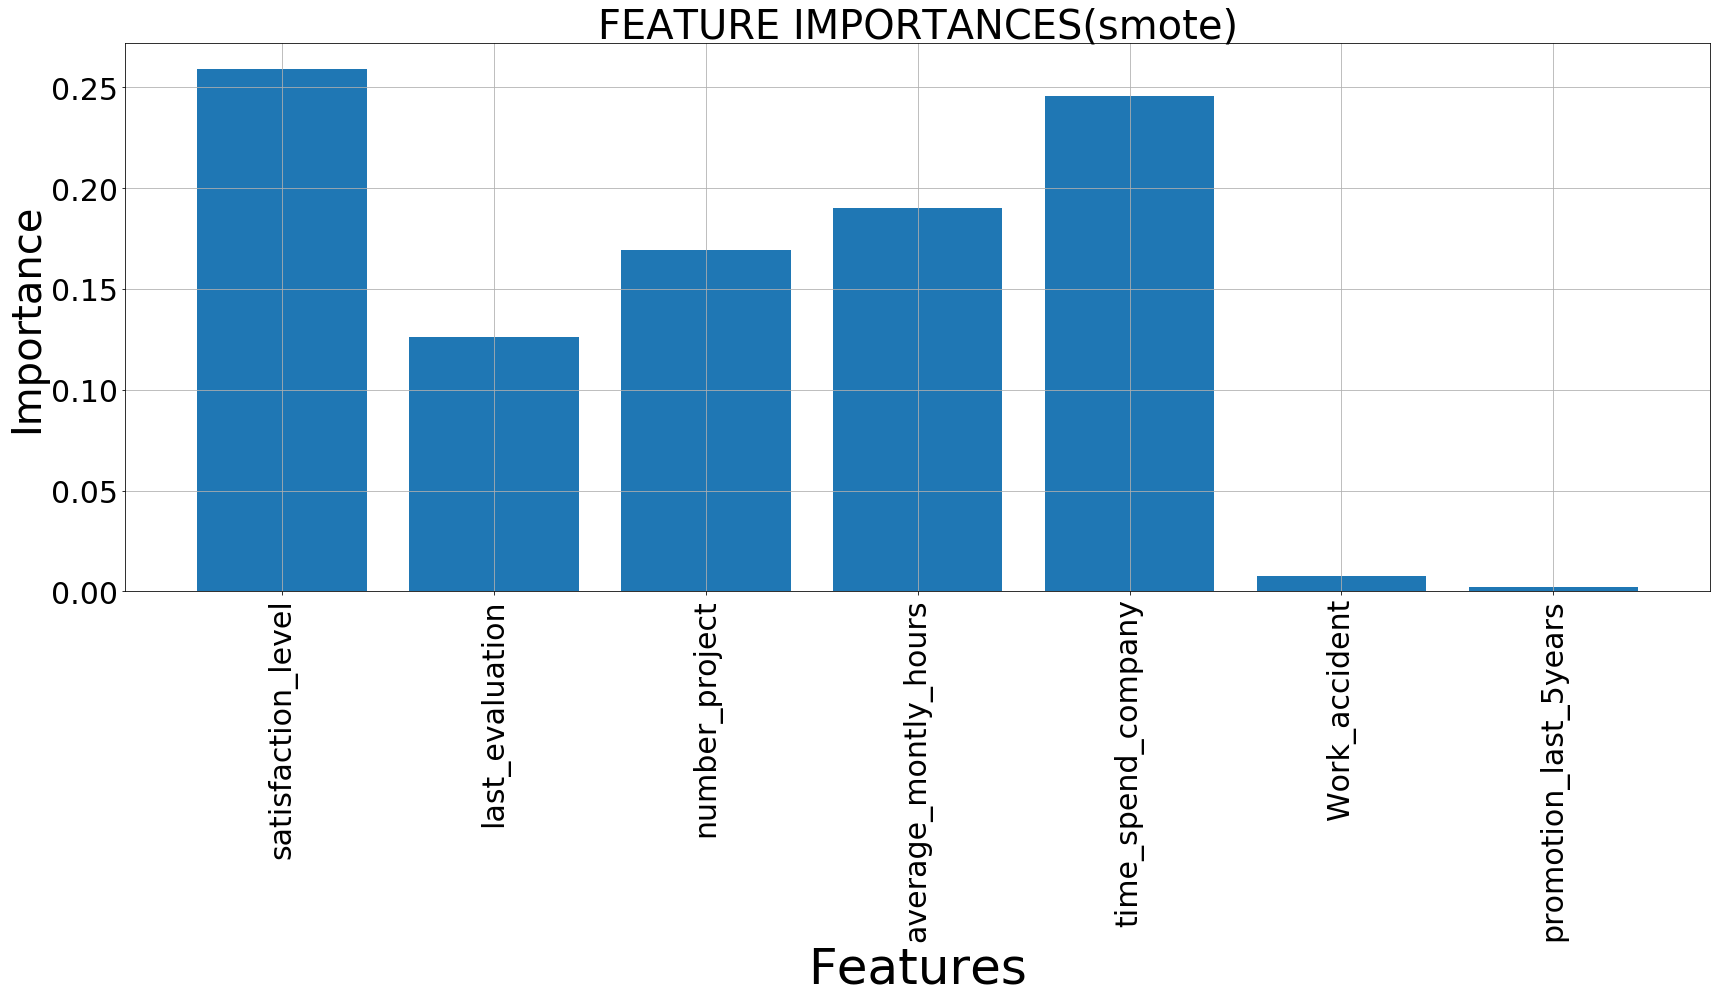

In [0]:
plt.figure(figsize=(24,14))
plt.bar(X_train_smote.columns,clf.feature_importances_)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Features', rotation=0, fontsize=50)
plt.ylabel('Importance', fontsize=40)
plt.title(f'FEATURE IMPORTANCES(smote)', fontsize=40)
plt.grid()
plt.tight_layout()

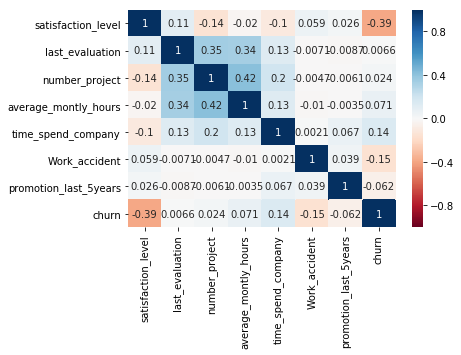

In [0]:
sns.heatmap(df.loc[:,['satisfaction_level','last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company','Work_accident', 'promotion_last_5years','churn']].corr(),
            cmap='RdBu',annot=True,vmin=-1,vmax=1)

In [0]:
y_pred_train=clf.predict(X_train_smote)
y_pred_test=clf.predict(X_test_scale)

In [0]:
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[9.99671557e-01 3.28443179e-04]
 [9.85329538e-04 9.99014670e-01]]


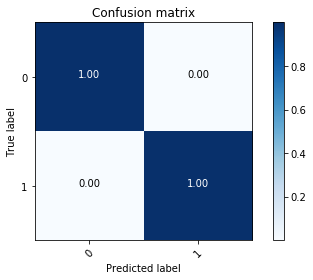

In [0]:
#train confusion matrix
plot_confusion_matrix(confusion_matrix(y_train_smote,y_pred_train),[0,1], normalize=True)

Normalized confusion matrix
[[0.99607672 0.00392328]
 [0.03399433 0.96600567]]


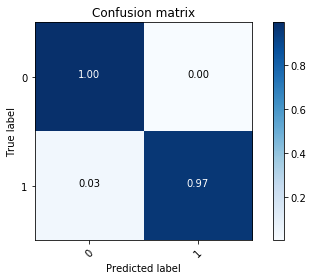

In [0]:
#test confusion matrix
plot_confusion_matrix(confusion_matrix(y_test,y_pred_test),[0,1], normalize=True)

In [0]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9810411938027764

In [0]:
log_model=LogisticRegression()
log_model.fit(X_train_scale,new_y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_train=log_model.predict(X_train_scale)
y_pred_test=log_model.predict(X_test_scale)

In [0]:
f1_score(new_y_train,y_pred_train)

0.7015650296815974

In [0]:
recall_score(y_test,y_pred_test)

0.6685552407932012

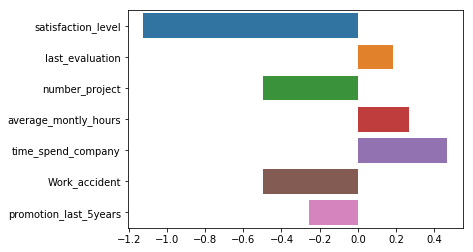

In [0]:
coeffs=pd.Series(log_model.coef_[0],new_X_train.columns)
sns.barplot(log_model.coef_[0],new_X_train.columns)


In [0]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7549402184785535

In [0]:
coeffs=pd.Series(log_model.coef_[0],new_X_train.columns)
coeffs.sort_values()

satisfaction_level      -1.124529
number_project          -0.498443
Work_accident           -0.495548
promotion_last_5years   -0.253944
last_evaluation          0.181508
average_montly_hours     0.268241
time_spend_company       0.468514
dtype: float64

In [0]:
from sklearn.dummy import DummyClassifier

In [0]:
#baseline dummy model comparison
dummy_model = DummyClassifier()

In [0]:
dummy_model.fit(X_train_scale, new_y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [0]:
dummy_model.score(X_train_scale, new_y_train)

0.5202502691065662

In [0]:
y_pred_train_dummy=dummy_model.predict(X_train_scale)
y_pred_test_dummy=dummy_model.predict(X_test_scale)


In [0]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test_dummy)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.47849235967210924

In [0]:
14999-3571

11428

In [0]:
f1_score(y_train,y_pred_train)

ValueError: ignored

In [0]:
recall_score(y_test,y_pred_test_dummy)

In [0]:
y_train.value_counts()

In [0]:
log_unscale=LogisticRegression()
log_unscale.fit(X_train,y_train)

y_unscale_pred_train=log_unscale.predict(X_train)
y_unscale_pred_test=log_unscale.predict(X_test)


In [0]:
f1_score(y_train,y_unscale_pred_train)

In [0]:
f1_score(y_test,y_unscale_pred_test)

In [0]:
deptdummy=pd.get_dummies(df.sales,prefix='dept')

In [0]:
df1=df.join(deptdummy)

In [0]:
df1.head()

In [0]:
salarydummy=pd.get_dummies(df.salary,prefix='salary')

In [0]:
df1=df1.join(salarydummy)

In [0]:
df1.head()

In [0]:
df1.columns

In [0]:
df1=df1.drop(columns='salary')

In [0]:
df1.head()

In [0]:
df1 = df1[['id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'dept_IT', 'dept_RandD',
       'dept_accounting', 'dept_hr', 'dept_management', 'dept_marketing',
       'dept_product_mng', 'dept_sales', 'dept_support', 'dept_technical',
       'salary_high', 'salary_low', 'salary_medium','churn']]

In [0]:
type(df1)

In [0]:
df1.to_csv('Adjusted HR DataSet.csv')

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt_model=DecisionTreeClassifier()
dt_model.fit(X_train_scale, y_train)
             
             

In [0]:
dt_model.feature_importances_.shape

In [0]:
X_train.columns.shape

In [0]:
sns.barplot(dt_model.feature_importances_,X_train.columns)

In [0]:
dt_y_pred_train=dt_model.predict(X_train_scale)
dt_y_pred_test=dt_model.predict(X_test_scale)

In [0]:
f1_score(y_train,dt_y_pred_train)

In [0]:
f1_score(y_test,dt_y_pred_test)

In [0]:
from sklearn.svm import LinearSVC

In [0]:
linear_svc_model=LinearSVC()
linear_svc_model.fit(X_train_scale,y_train)

In [0]:
linear_svc_model.score(X_train_scale, y_train)

In [0]:
linear_svc_model.score(X_test_scale, y_test)

In [0]:
svc_y_pred_train=linear_svc_model.predict(X_train_scale)
svc_y_pred_test=linear_svc_model.predict(X_test_scale)

In [0]:
f1_score(y_train,svc_y_pred_train)

In [0]:
f1_score(y_test,svc_y_pred_test)

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn_model=KNeighborsClassifier()

In [0]:
knn_model.fit(X_train_scale, y_train)

In [0]:
knn_y_pred_train=knn_model.predict(X_train_scale)
knn_y_pred_test=knn_model.predict(X_test_scale)

In [0]:
f1_score(y_train,knn_y_pred_train)

In [0]:
f1_score(y_test,knn_y_pred_test)

In [0]:
df['Work_accident'].unique()

In [0]:
df.churn.sum()

In [0]:
df.loc[df['sales']=='sales'].shape

In [0]:
df.loc[df['sales']=='sales'].describe()

In [0]:
df.loc[df['sales']=='technical'].describe()

In [0]:
df.loc[df['sales']=='support'].describe()

In [0]:
df.groupby(df['sales']).churn.sum()

In [0]:
df.groupby(['sales','Work_accident']).churn.sum().sort_values().reset_index()

In [0]:
df.shape

In [0]:
df['salary'].unique()

In [0]:
df.columns

In [0]:
df['number_project'].max()

In [0]:
df['number_project'].min()

In [0]:
df['sales'].unique()

In [0]:
df_satis_level_bigger_than_80=df.loc[df['satisfaction_level']>=0.8]

In [0]:
df_satis_level_bigger_than_80.describe()

In [0]:
df_satis_level_bigger_than_80.loc[df_satis_level_bigger_than_80['last_evaluation']>=0.8].describe()

In [0]:
df_satis_level_less_than_80=df.loc[df['satisfaction_level']<=0.8]

In [0]:
df_satis_level_less_than_80.loc[df_satis_level_less_than_80['last_evaluation']<=0.8].churn.sum()

In [0]:
df.churn.sum()

In [0]:
552/3571

In [0]:
df.average_montly_hours.mean()

In [0]:
df.loc[df['last_evaluation']>=0.8].average_montly_hours.mean()

In [0]:
df_satis_level_bigger_than_80.loc[df_satis_level_bigger_than_80['last_evaluation']>=0.8].average_montly_hours.mean()

In [0]:
df.loc[df['sales']=='sales'].average_montly_hours.mean()

In [0]:
df.loc[df['sales']=='IT'].average_montly_hours.mean()

In [0]:
df.loc[df['sales']=='marketing'].average_montly_hours.mean()

In [0]:
df.loc[df['sales']=='hr'].average_montly_hours.mean()

In [0]:
df.average_montly_hours.mean()

In [0]:
df.number_project.mean()

In [0]:
df.shape

In [0]:
df_satis_increase.loc[df_satis_increase['number_project']==6].shape

In [0]:
df_satis_increase.loc[df_satis_increase['number_project']==5].shape

In [0]:
df_satis_increase.loc[df_satis_increase['number_project']==4].shape

In [0]:
df_satis_increase.loc[df_satis_increase['number_project']==2].shape

In [0]:
df_satis_increase.groupby(['number_project']).churn

In [0]:
df.isna().sum()

In [0]:
df['average_montly_hours'].mean()

In [0]:
df_satis_increase_churn['average_montly_hours'].mean()

In [0]:
df_satis_decrease_churn['average_montly_hours'].mean()

In [0]:
df1=df

In [0]:
df1.rename(columns={'average_montly_hours':'average_monthly_hours',
                          }, 
                 inplace=True)

In [0]:
df1.head()